### Tratamento e Transformação de Dados:

1. Tratamento e Transformação de Dados
2. Limpeza de dados faltantes.
3. Normalização dos valores.
4. Codificação de variáveis categóricas.
5. Realização de transformações necessárias para os modelos. .

#### Imports

In [163]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split,  ShuffleSplit, KFold, cross_validate
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.dummy import DummyRegressor
from sklearn.svm import SVR
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import joblib

#### Lendo arquivo

In [165]:
df= pd.read_csv("../data/raw/data.csv")
df

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2


#### Tranzendo o dicionário

In [167]:
data_path = Path('../data/external/dictionary.csv')
df_dictionary = pd.read_csv(data_path, sep=',') 
df_dictionary

,variavel,descricao,tipo,subtipo
0,total_bill,Valor total da conta,quantitativa,contínua
1,tip,Gorjeta entregue ao garçom,quantitativa,contínua
2,sex,Gênero da pessoa pagante,qualitativa,nominal
3,smoker,Se o cliente é fumante ou não fumante,qualitativa,nominal
4,day,Dia da semana,qualitativa,cíclica
5,time,Se é almoço ou jantar,qualitativa,nominal
6,size,Tamanho do grupo de pessoas que frequentam o r...,quantitativa,discreta


#### Informações do dataset

In [169]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   total_bill  244 non-null    float64
 1   tip         244 non-null    float64
 2   sex         244 non-null    object 
 3   smoker      244 non-null    object 
 4   day         244 non-null    object 
 5   time        244 non-null    object 
 6   size        244 non-null    int64  
dtypes: float64(2), int64(1), object(4)
memory usage: 13.5+ KB


### Avaliando explicitamente se há brancos e nulos 

In [171]:
df.isnull().sum()

total_bill    0
tip           0
sex           0
smoker        0
day           0
time          0
size          0
dtype: int64

#### Verificando duplicatas

In [173]:
duplicados = df.duplicated()

# Exibindo as linhas duplicadas
linhas_duplicadas = df[duplicados]

# Mostrando o número de duplicados
num_duplicados = linhas_duplicadas.shape[0]

# Exibindo as informações
print(f"Número de linhas duplicadas: {num_duplicados}")
print(f"Linhas duplicadas: {linhas_duplicadas}")

Número de linhas duplicadas: 1
Linhas duplicadas:      total_bill  tip     sex smoker   day   time  size
202        13.0  2.0  Female    Yes  Thur  Lunch     2


#### Removendo duplicada

In [175]:
df = df.drop_duplicates()

#### Análise geral de dados categóricos

In [177]:
print("Tabela de características das variáveis qualitativas:\n")
df.describe(include=['object'])

Tabela de características das variáveis qualitativas:



,sex,smoker,day,time
count,243,243,243,243
unique,2,2,4,2
top,Male,No,Sat,Dinner
freq,157,151,87,176


#### Análise geral de dados númericos


In [179]:
print("Tabela de características das variáveis quantitativas:\n")
df.describe().round(2)

Tabela de características das variáveis quantitativas:



,total_bill,tip,size
count,243.00,243.00,243.00
mean,19.81,3.00,2.57
std,8.91,1.39,0.95
min,3.07,1.00,1.00
25%,13.38,2.00,2.00
50%,17.81,2.92,2.00
75%,24.17,3.58,3.00
max,50.81,10.00,6.00


##### Verificando valores discrepantes (Detectando outliers em cada coluna numérica)

In [181]:
numericas = df.select_dtypes(include='number')

outliers = {}
for coluna in numericas.columns:
    Q1 = numericas[coluna].quantile(0.25)
    Q3 = numericas[coluna].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR

    # Filtrar valores fora dos limites
    outliers[coluna] = df[(numericas[coluna] < limite_inferior) | (numericas[coluna] > limite_superior)]

for coluna, valores in outliers.items():
    print(f"Outliers na coluna \n{coluna}:\n", valores)

Outliers na coluna 
total_bill:
      total_bill    tip     sex smoker   day    time  size
59        48.27   6.73    Male     No   Sat  Dinner     4
102       44.30   2.50  Female    Yes   Sat  Dinner     3
142       41.19   5.00    Male     No  Thur   Lunch     5
156       48.17   5.00    Male     No   Sun  Dinner     6
170       50.81  10.00    Male    Yes   Sat  Dinner     3
182       45.35   3.50    Male    Yes   Sun  Dinner     3
184       40.55   3.00    Male    Yes   Sun  Dinner     2
197       43.11   5.00  Female    Yes  Thur   Lunch     4
212       48.33   9.00    Male     No   Sat  Dinner     4
Outliers na coluna 
tip:
      total_bill    tip     sex smoker   day    time  size
23        39.42   7.58    Male     No   Sat  Dinner     4
47        32.40   6.00    Male     No   Sun  Dinner     4
59        48.27   6.73    Male     No   Sat  Dinner     4
141       34.30   6.70    Male     No  Thur   Lunch     6
170       50.81  10.00    Male    Yes   Sat  Dinner     3
183       23.

#### Estruturação de variável
- Variáveis categóricas são convertidas para o tipo categoryline

In [183]:
df = df.astype({col: 'category' for col in df.select_dtypes(include='object').columns})

print(df.dtypes)

total_bill     float64
tip            float64
sex           category
smoker        category
day           category
time          category
size             int64
dtype: object


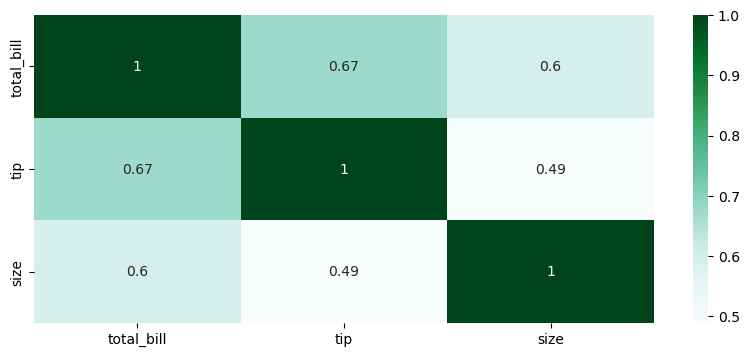

In [184]:
# Calcula a matriz de correlação
corr = df.corr(numeric_only=True)
features = corr.index

# Cria o gráfico de calor
plt.figure(figsize=(10, 4))
ax = sns.heatmap(df[features].corr(), annot=True, cmap='BuGn')
plt.show()

#### Separando a variável X (Tip) das variáveis Y(total_bill e size)
*coluna independente (X) e dependentes (Y) como argumentos

In [209]:
# Definindo a variável-alvo
target_variable = 'tip'

# Identificando variáveis inúteis (nenhuma nesse caso)
useless_variables = (
    df_dictionary
    .query("tipo == 'inútil'")
    .variavel
    .to_list()
)

# Variáveis nominais 
nominal_variables = (
    df_dictionary
    .query("subtipo == 'nominal' and variavel != @target_variable")
    .variavel
    .to_list()
)

# Variáveis contínuas
continuous_variables = (
    df_dictionary
    .query("subtipo == 'contínua' and variavel != @target_variable")
    .variavel
    .to_list()
)

# Variáveis discretas
discrete_variables = (
    df_dictionary
    .query("subtipo == 'discreta' and variavel != @target_variable")
    .variavel
    .to_list()
)

# Separando X e y para o modelo
X = df.drop(columns=[target_variable] + useless_variables)
y = df[target_variable]


In [211]:
print("Variáveis nominais:", nominal_variables)
print("Variáveis contínuas:", continuous_variables)
print("Variáveis discretas:", discrete_variables)
print("\nX (features):\n", X)
print("\ny (target):\n", y)

Variáveis nominais: ['sex', 'smoker', 'time']
Variáveis contínuas: ['total_bill']
Variáveis discretas: ['size']

X (features):
      total_bill     sex smoker   day    time  size
0         16.99  Female     No   Sun  Dinner     2
1         10.34    Male     No   Sun  Dinner     3
2         21.01    Male     No   Sun  Dinner     3
3         23.68    Male     No   Sun  Dinner     2
4         24.59  Female     No   Sun  Dinner     4
..          ...     ...    ...   ...     ...   ...
239       29.03    Male     No   Sat  Dinner     3
240       27.18  Female    Yes   Sat  Dinner     2
241       22.67    Male    Yes   Sat  Dinner     2
242       17.82    Male     No   Sat  Dinner     2
243       18.78  Female     No  Thur  Dinner     2

[243 rows x 6 columns]

y (target):
 0      1.01
1      1.66
2      3.50
3      3.31
4      3.61
       ... 
239    5.92
240    2.00
241    2.00
242    1.75
243    3.00
Name: tip, Length: 243, dtype: float64


#### Pipelines de pré-processamento por tipo de variável:

In [213]:
nominal_preprocessor = Pipeline(steps=[
    ("missing", SimpleImputer(strategy='most_frequent')),  # Substituir valores faltantes pela moda
    ("encoding", OneHotEncoder(sparse_output=False)),  # Codificação one-hot
])

continuous_preprocessor = Pipeline(steps=[
    ("missing", SimpleImputer(strategy='mean')),  # Substituir valores faltantes pela média
    ("normalization", StandardScaler()),  # Normalização (média = 0, desvio padrão = 1)
])

discrete_preprocessor = Pipeline(steps=[
    ("missing", KNNImputer()),  # Substituir valores faltantes com base nos vizinhos mais próximos
    ("normalization", StandardScaler()),  # Normalização
])

#### Selecionando variáveis com base no dados do dicionário:

In [215]:
# Criando o transformador por tipo de variável
preprocessor = ColumnTransformer(transformers=[
    ("nominal", nominal_preprocessor, nominal_variables),
    ("continuous", continuous_preprocessor, continuous_variables),
    ("discrete", discrete_preprocessor, discrete_variables),
])

In [217]:
X_preprocessed = preprocessor.fit_transform(X)

In [219]:
print("Dados pré-processados:")
print(X_preprocessed)

Dados pré-processados:
[[ 1.          0.          1.         ...  0.         -0.31758409
  -0.60187261]
 [ 0.          1.          1.         ...  0.         -1.06547102
   0.45032195]
 [ 0.          1.          1.         ...  0.          0.13452199
   0.45032195]
 ...
 [ 0.          1.          0.         ...  0.          0.32121257
  -0.60187261]
 [ 0.          1.          1.         ...  0.         -0.2242388
  -0.60187261]
 [ 1.          0.          1.         ...  0.         -0.11627317
  -0.60187261]]


* Este notebook executa a limpeza e preparação de dados, lida com valores ausentes, outliers e codificação de variáveis categóricas. O uso de pipelines do scikit-learn tornou o processo mais organizado e eficiente.